In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Supervised Machine Learning - 

After dimensionality reduction, we can now use supervised learning methods to train a classifier and make predictions from new signals. In this notebook, I perform some basic testing to compare the following classifiers - 

* Logistic Regression
* Support Vector Machines
* Naive Bayes
* Decision Trees
* Random Forest
* K-Nearest Neighbours
* Neural Network
<br>
<br>

After the testing, we select the algorithm with overall best performance and optimize it further. 

__Methodology__ - The data first undergoes PCA transformation to reduce the dimensionality. Then, for each classifier, we perform training with grid search and cross validation to find the optimal choice of parameters. Each classifier is trained with 40-90% of the original data and tested with the remaining dataset. Overfitting is checked by comparing the training scores with cross validation scores.  



In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import time, glob, os, math
from matplotlib import cm 

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

#Classifiers
from sklearn.tree import DecisionTreeClassifier as DT, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier



import matplotlib as mpl
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)
mpl.rc('axes', labelsize=16, grid=True)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)



In [3]:
random_state = 12

In [4]:
#Basic Functions and Classes

def read_paramvalue(metafile, parameter):
    '''Return the parameter value from data
    
    Parameters:
    metafile (str) - Metadata filepath
    parameter (str) - parameter name
    '''
   
    assert(os.path.exists(metafile)),"Path to metadata file does not exist"
    
    datafile = open(metafile,'r')
    datafile.seek(0)
    for line in datafile:
        if parameter in line:
            break
    
    line = line.split(',')
    
    #rstrip - remove any trailing charaters
    data_value = line[-1].rstrip()
    datafile.close()
    return data_value


def plot(x, y, xlabel, ylabel, xlim=None, ylim=None, log=None, title=None):     #Create a plot
    '''Generate a line plot of y vx x
    
    Parameters - 
    x,y - Dictionaries - {'label_1':data_1,...'label_n':data_n} - Ensure x and y have same keys/labels
    xlabel, ylabel - strings
    '''
    plt.figure(figsize=(12,6))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for key in x:
        plt.plot(x[key], y[key], ls=next(linecycler), label=key)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim!=None:
        plt.xlim(xlim[0],xlim[1])
    if ylim!=None:
        plt.ylim(ylim[0],ylim[1])
        
    if log=='x': plt.xscale('log')
    elif log=='y': plt.yscale('log')
    elif log=='both': 
        plt.xscale('log')
        plt.yscale('log')
        
    if title!=None:
        plt.title(title, y=1.04, fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()
    
    
def scatter(ax, x, y, clr, xlabel, ylabel, title=None, legend=True):     #Create a scatter plot
    '''Generate a scatter plot 
       ax - subplot
       x, y - numpy arrays
       xlabel, ylabel title - strings  
    '''
    clr_label = {0:'orange', 1:'forestgreen', 2:'deepskyblue',3:'gold', 4:'b', 5:'k', 6:'red', 7:'darkmagenta' }
    names = {'AlignedSpins':0,'NonSpinning':1,'Precessing':2}
    #target_names = np.vectorize(names.get)(clr)
    target_labels =  np.vectorize(clr_label.get)(clr) #(target_names)
   
    ax.scatter(x,y,facecolors=target_labels, edgecolors=None) 

    orange_dot= plt.scatter([], [], color=clr_label[0], label='AlignedSpin')
    green_dot= plt.scatter([], [], color=clr_label[1], label='NonSpinning')
    blue_dot= plt.scatter([], [], color=clr_label[2], label='Precessing')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title!=None:
        ax.set_title(title)
    if legend: ax.legend(handles=[orange_dot, green_dot, blue_dot])
    return ax


class waveform():
    
    def __init__(self, wf_filepath, wf_metadata_file):
        
        assert os.path.exists(wf_filepath), "Waveform file at path %s not found"%wf_filepath
            
        self.t, self.hp, self.hx = np.loadtxt(wf_filepath, unpack=True, usecols=(0,1,2))
        
        self.dt  = self.t[2]-self.t[1]
        
        self._amplitude  = np.sqrt(self.hp**2 + self.hx**2)
        self._phase = -1.*np.unwrap(np.arctan2(self.hp,self.hx))
        self._gwfreq  = np.gradient(self.phase)/np.gradient(self.t)
        
        self._freq, self._hf_plus, self._hf_cross = self.fourier_transform()
        self._hf_amplitude = np.sqrt(np.absolute(self._hf_plus)**2 + np.absolute(self._hf_cross)**2)
        
        #Read parameters from metadata file
        metafile = wf_metadata_file
        self.name =  read_paramvalue(metafile, 'name')
        
        self.m1 = read_paramvalue(metafile, 'mass1')
        self.m2 = read_paramvalue(metafile, 'mass2')
        
        self.a1x = read_paramvalue(metafile, 'spin1x')
        self.a1y = read_paramvalue(metafile, 'spin1y')
        self.a1z = read_paramvalue(metafile, 'spin1z')
        
        self.a2x = read_paramvalue(metafile, 'spin2x')
        self.a2y = read_paramvalue(metafile, 'spin2y')
        self.a2z = read_paramvalue(metafile, 'spin2z')
    
        self.ecc = read_paramvalue(metafile, 'eccentricity')
        self.spin_type = read_paramvalue(metafile, 'spin-type')
        self.f_low = read_paramvalue(metafile, 'f_lower_at_1MSUN')
        
    #Declare amplitude, phase and GW frequency as properties so any modification to strain data (for eg windowing)
    #is automatically accounted for. 
    
    def get_amplitude(self):
        return self._amplitude

    
    def set_amplitude(self): 
        print('Amplitude Setter function called')
        self._amplitude = np.sqrt(self.hp**2 + self.hx**2)

    amplitude = property(get_amplitude, set_amplitude)
    
    
    def get_phase(self):
        return self._phase

    def set_phase(self): 
        self._phase = -1.*np.unwrap(np.arctan2(self.hp, self.hx))
     
    phase = property(get_phase, set_phase)
    
    
    def get_gwfreq(self):
        return self._gwfreq

    def set_gwfreq(self): 
        self._gwfreq = np.gradient(self.phase)/np.gradient(self.t)

    gwfreq = property(get_gwfreq, set_gwfreq) 
    
    
    def  get_hf_plus(self):
        return self._hf_plus

    def set_hf_plus(self): 
        self._hf_plus = np.abs(np.fft.fft(self.hp))*self.dt
   
    hf_plus= property(get_hf_plus, set_hf_plus) 
    
    
    def get_hf_cross(self):
        return self._hf_cross

    def set_hf_cross(self): 
        self._hf_cross = np.abs(np.fft.fft(self.hx))*self.dt
    
    hf_cross= property(get_hf_cross, set_hf_cross) 
    
   
    def get_hf_amplitude(self):
        return self._hf_amplitude

    def set_hf_amplitude(self): 
        self._hf_amplitude = np.sqrt(np.absolute(self._hf_plus)**2 + np.absolute(self._hf_cross)**2)
    
    hf_amplitude= property(get_hf_amplitude, set_hf_amplitude) 
   
    def get_freq(self):
        return self._freq

    def set_freq(self): 
        self._freq = np.fft.fftfreq(len(self.hf_plus), self.dt)
   
    freq = property(get_freq, set_freq)
    
   
    def update_properties(self):
        print('Update properties called')
        t = self.t
        re = self.hp
        im = self.hx
       
        self.set_amplitude()
        self.set_phase()
        self.set_gwfreq()
        self.set_hf_plus()
        self.set_hf_cross()
        self.set_freq()
        
    def fourier_transform(self ):
        hf_plus  = np.abs(np.fft.fft(self.hp))*self.dt
        hf_cross = np.abs(np.fft.fft(self.hx))*self.dt
        hf = np.sqrt(hf_plus**2  + hf_cross**2)
        freq = np.fft.fftfreq(len(hf), self.dt)
        return freq, hf_plus, hf_cross

    def mean_centring(self):
        max_amp = np.amax(self.amp)
        tmax = self.t[amp==max_amp]
        self.t = self.t-tmax
        
         
    def window_beginning(self, window_length):
        old_t_start = t[0]
        new_t_start = old_t_start + window_length
        
        self.hp = self.hp[self.t>new_t_start]
        self.hx = self.hx[self.t>new_t_start]
        
        self.t = self.t[self.t>new_t_start]
        self.update_properties()
        
    def window_ends(self, window_length):
        old_t_end = t[-1]
        new_t_end = old_t_end - window_length
        
        self.hp = self.hp[self.t<new_t_end]
        self.hx = self.hx[self.t<new_t_end]
        
        self.t = self.t[self.t<new_t_end]
        


class classifier():
  
    def __init__(self):
        
        self.name = ""
        self.training_fraction = 0
        
        self.cv_score       = 0
        self.training_score = 0
        self.testing_score  = 0
        self.total_time     = 0
        self.best_params    = 0
       
        

In [5]:
#Principal Component Analysis and ML Classifier
def func_PCA(n_comp, data, rs):
    ''' Compute n PCA components and apply to given data
    --------------------------------------------
    n_comp - type int - number of PCA components
    data - type numpy matrix - training data
    random_state - type int - random state for PCA
    '''
    
    num_samples, num_features = np.shape(data)
    time_init = time.time()
    clf = PCA(svd_solver='full', n_components=n_comp, random_state=rs)   
    transformed_data = clf.fit_transform(data)
    #var = clf.explained_variance_
    score = clf.score(data)
    time_pca = time.time() - time_init
    
    #print("Projected {} samples from {} to {} with score {}" .format(num_samples, num_features, n_comp, score))
    return transformed_data, time_pca


def ml_classifier(clf, params, inputdata, outputdata, trainsize, pca_comp, rs, plot_decisiontree=False, verbose=0,parallelize=False):
    '''Compute the best optimal parameters and scores for classifier clf using GridSearch algorithm 
    and apply it to standardized data. 
    ----------------------------------------------------------------------------------------
    clf - ML classifier (sklearn clf object)
    params (type dict) - dict with parameter name as key and range of parameter values
    to search over (check GridSearch algorithm)
    inputdata (numpy matrix) - input dataset X
    outputdata (numpy array) - output dataset Y
    trainsize (float) - fraction of total data to be trained (between 0 to 1)
    pca_comp(int) - number of PCA components
    rs (int) - random state
    plot_decisiontree (boolean) - if true, then plot the decision tree 
    verbose(int) - print summary of results
    parallelize (boolean) - parallelize grid search 
    '''
    
    start_time = time.time()
    data = np.copy(inputdata)
    y    = np.copy(outputdata)
    data_train, data_test, y_train, y_test = train_test_split(data, y, train_size=trainsize, test_size=1-trainsize, random_state=rs)
    
    #Standardize the data before applying PCA
    SS_data = StandardScaler()
    data_train =  SS_data.fit_transform(data_train)
    data_test = SS_data.transform(data_test)
    
    standardization_time = time.time() 
    
    #Apply PCA
    data_train_pca, pca_train_time = func_PCA(pca_comp, data_train, rs)
    data_test_pca, pca_test_time = func_PCA(pca_comp, data_test, rs)
    pca_time = time.time() 
    
    #Perform a grid search over given parameters
    param_grid=params 
    if parallelize:
        nprocs=-1
    else:
        nprocs=1
    search = GridSearchCV(clf, param_grid, cv=5, n_jobs=nprocs)
    
    #Compute the cross validation, training and test scores
    search.fit(data_train_pca, y_train)
    score_train = search.score(data_train_pca, y_train)
    
    #Cross validation score for classifier with best parameters
    cv_scores = cross_val_score(search, data_train_pca, y_train, cv=5)
    score_test = search.score(data_test_pca,y_test)
    
    
    gridsearch_time = time.time() 
    
    if plot_decisiontree:
        plt.figure()
        plot_tree(clf)
        plt.close()
        
    if verbose>1:
        
        print("Training Size = %g (%.3g), Test Size = %g(%0.3g)"%(trainsize, len(y_train), (1-trainsize), len(y_test)))
        print("Time Taken: Standardization = %g, PCA = %g, GridSearch = %g, Total Time = %g"%(standardization_time-start_time, pca_time-standardization_time, gridsearch_time-pca_time, gridsearch_time-start_time))
        print("Cross-Validation Score = %.3g (+/- %0.2g) , Training Score = %g, Testing Score = %.3g \n\n"%(cv_scores.mean(), cv_scores.std()*2, score_train, score_test))
            
    
    clf_performance = classifier()
    clf_performance.name = clf.__class__.__name__
    clf_performance.training_fraction = trainsize
    clf_performance.cv_score       = cv_scores
    clf_performance.training_score = score_train
    clf_performance.testing_score  = score_test
    clf_performance.total_time     = gridsearch_time-start_time
    clf_performance.best_params    = search.best_params_
    
    return clf_performance



In [6]:
os.chdir('/localdata2/bkhamesra3/MachineLearning/GW-MLClassification/Data/')


## Building Data

Collect all waveforms and spin-type. Convert the spin-type category from string to numerical labels. 

In [7]:
#Loading the Dataset

waveform_collection = []
GT_filepaths = sorted(glob.glob("FilteredData/GT*.txt"))
SXS_filepaths = sorted(glob.glob("FilteredData/SXS*.txt"))


for wf_file_gt in GT_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_gt).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_gt, metadata_file)
    waveform_collection.append(wf)
    
for wf_file_sxs in SXS_filepaths:
    
    metadata_file = os.path.join('Metadata','Metadata_'+os.path.basename(wf_file_sxs).split('.txt')[0]+'.csv')
    wf = waveform(wf_file_sxs, metadata_file)
    waveform_collection.append(wf)
    


In [8]:
#Concatenate plus and cross polarization
def concat_wf_timedata(wf):
    '''Concatenate the real and imaginary components of waveform in time domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((wf.hp, wf.hx))
    
    return data

def concat_wf_freqdata(wf):
    '''Concatenate the plus and cross polarization components of waveform in frequency domain'''
    #print(wf.name, wf.spin_type)
    data = np.concatenate((np.absolute(wf.hf_plus)[wf.freq>0], np.absolute(wf.hf_cross)[wf.freq>0]))
    
    return data


waveform_collection  = np.asarray(waveform_collection)

# waveform_data_ht - each row represents concatenated data corresponding to one waveform in order (t, real, imag)
waveform_data_ht = list(map(concat_wf_timedata, waveform_collection))
waveform_data_ht = np.matrix(waveform_data_ht)

# waveform_data_hf - each row represents concatenated data corresponding to one waveform in order (f, FT(real), FT(imag))
waveform_data_hf = list(map(concat_wf_freqdata, waveform_collection))
waveform_data_hf = np.matrix(waveform_data_hf)

# Output
y = [wf.spin_type for wf in waveform_collection]

# Convert spin labels from string to numbers
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)



In [9]:
#Train a classifier and analyse results

def analyse_classifier(clf, params, data, y, trainingdata_frac, pca_numcomp, rs, verbose=0, show_plot=True, parallelize=False):
    '''Train classifier for given training data size and evaluate the performance. 
    ----------------------------------------------------------------------------------------
    clf - ML classifier (sklearn clf object)
    params (type dict) - dict with parameter name as key and range of parameter values
    to search over (check GridSearch algorithm)
    data (numpy matrix) - input dataset X
    y (numpy array) - output dataset Y
    traindata_frac(float) - numpy array of fraction of training data with each element between 0 to 1
    pca_numcomp(int) - number of PCA components
    rs (int) - random state
    show_plot(boolean) - display plot of performance of classifier
    verbose(int) - print summary of results
    parallelize (boolean) - parallelize grid search 
    '''
    
    clf_cv_score_mean, clf_cv_score_std, clf_train_score_arr, clf_test_score_arr, clf_total_time_arr = \
                                                                            np.zeros((5, len(trainingdata_frac)))
    clf_output = {}
    
    print('-'*100)

    #Run the ML model over training dataset and evluate its performance using cross valiation, testing and time taken
    for i in range(len(trainingdata_frac)):
        
        clf_performance = ml_classifier(clf, params, data, y, trainingdata_frac[i], pca_numcomp, rs, verbose=verbose,parallelize=parallelize)
        clf_cv_score_mean[i]   =  clf_performance.cv_score.mean()
        clf_cv_score_std[i]    =  clf_performance.cv_score.std()
        clf_train_score_arr[i] =  clf_performance.training_score
        clf_test_score_arr[i]  =  clf_performance.testing_score
        clf_total_time_arr[i]  =  clf_performance.total_time
        clf_output[trainingdata_frac[i]] = clf_performance
        if verbose>0: print("Training Fraction = {:0.2g}, Best Model parameters - {}".format(trainingdata_frac[i], clf_performance.best_params))
    
    #Plots the performance of the classifier
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))      
    
    cv_plot = ax1.plot(trainingdata_frac, clf_cv_score_mean, c='C1', label=r'$CV Score \pm 2\sigma$')
    #ax1.plot(trainingdata_frac, clf_cv_score_mean+2*clf_cv_score_std, ls='--', c='C1' )
    #ax1.plot(trainingdata_frac, clf_cv_score_mean-2*clf_cv_score_std, ls='--', c='C1' )
    #ax1.fill_between(trainingdata_frac, clf_cv_score_mean-2*clf_cv_score_std, clf_cv_score_mean, color='C1', alpha=0.3)
    #ax1.fill_between(trainingdata_frac, clf_cv_score_mean+2*clf_cv_score_std, clf_cv_score_mean, color='C1', alpha=0.3)
    ax1.plot(trainingdata_frac, clf_train_score_arr, ls='--', c='C2', label='Training Score')
    ax1.plot(trainingdata_frac, clf_test_score_arr, c='C0', label='Test Score')
     
    ax1.set_xlabel('Training Size')
    ax1.set_ylabel('Scores')
    ax1.legend()
    
    ax2.plot(trainingdata_frac, clf_total_time_arr )
    ax2.set_xlabel('Training Size')
    ax2.set_ylabel('Total Time')
            
    if show_plot:fig.suptitle(clf_performance.name, fontsize=15)
    if show_plot: plt.show()
    plt.close()
    
    return clf_output

## Comparing Classifiers

###  Logistic Regression 

Let's start with a linear model. Logistic Regression method can be used to model the probability distribution for Y given the dataset X. In this model, we estimate the log likelihood of observing Y given X as
<br>
<br>
$$\log (\mathcal{L}(W|Y;X)) = log(\mathcal{P}(Y|X,W)) = \sum log (\mathcal{P}(y_i|x_i, W))$$
<br>
where conditional probability of y is given in terms of sigmoid function as 
$$\mathcal{P}(Y=1|X,W) = \frac{1}{1+e^{-W^TX}}$$
$$\mathcal{P}(Y=0|X,W) = 1-\frac{1}{1+e^{-W^TX}}$$
<br>
To find $W$, one needs to maximize the likelihood estimate, which can be achieved using different solvers. To avoid overfitting and for numerical stability, sklearn adds a regularization term of form $||W||_1$ (L1 Regulatization) or $||W^TW||_2$ (L2 regularization) to the cost function, strength of which is controlled by 1/C. Hence, we perform a grid search over these two parameters. The penalty is fixed to 'l2' due to limited support for different solvers. 

__Parameters__ - 
* Fixed - Here, we use 'L2' type regularization term due to limited compatibility of 'L1' with different solers. Maximum number of iterations are increased to 1000 for proper convergence. 
* Variable - Regulatization strength parameter 'C' is varied over from 0.001-10 and different solvers are tested. 


__Results__ -  

* Training - We see that logistic regression works quite well ranging from 76% to 79% accuracy in cross validation scores. However, to reach its best results, it utilizes a singificant proportion of data for training. This can be problematic for cases where training datasets are larger as time for training increases almost linearly. 
* Test scores are slightly higher ranging from 78%-81% for training fraction of 0.5-0.8. The slight improvement of test results in comparison to CV scores is reflected in low values of C (or higher regularization strengths) which suggests more generalizable models avoiding possible overfitting. 
* Best parameters - Smaller values of "C" are preferred which places higher constraints on weights making the model more generalizable. Newton's solver works consistently well due to smaller size of the data

In [18]:
%%time
clf = LogisticRegression(penalty='l2', max_iter=1000)  
params={'C':10.**np.arange(-3,1,1),'solver':['newton-cg', 'lbfgs','sag', 'saga']}
verbose=1 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.1)

lr = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=False)
print("Parameter analysis completed \n\n")
    
    

----------------------------------------------------------------------------------------------------
Training Fraction = 0.5, Best Model parameters - {'C': 0.001, 'solver': 'newton-cg'}
Training Fraction = 0.6, Best Model parameters - {'C': 0.001, 'solver': 'newton-cg'}
Training Fraction = 0.7, Best Model parameters - {'C': 0.001, 'solver': 'newton-cg'}
Training Fraction = 0.8, Best Model parameters - {'C': 0.01, 'solver': 'newton-cg'}
Parameter analysis completed 


CPU times: user 6.32 s, sys: 2.23 s, total: 8.54 s
Wall time: 28.9 s


newton-cg


----------------------------------------------------------------------------------------------------


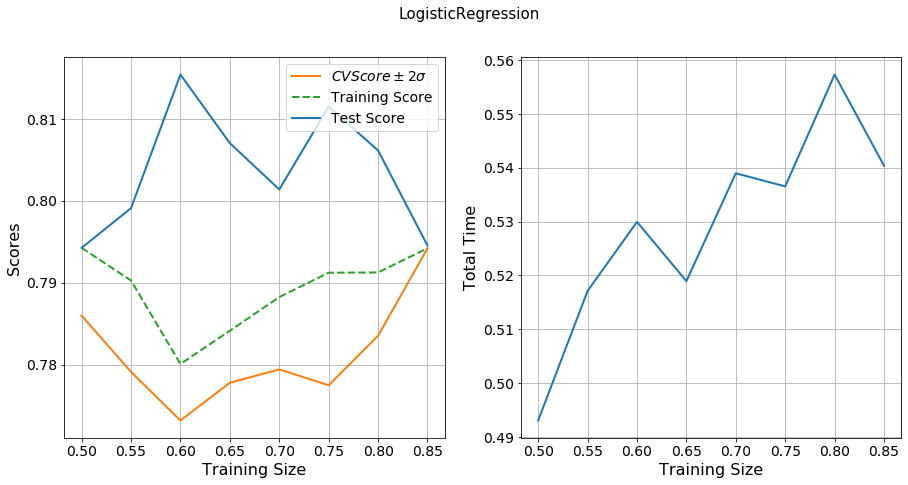

In [83]:
def find_bestparam(param_name):
    a = np.asarray([lr[key].best_params[param_name] for key in lr.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]
  
    
best_C = find_bestparam('C')
best_solver = find_bestparam('solver')


clf = LogisticRegression(penalty='l2', max_iter=1000, C=best_C, solver=best_solver, random_state=random_state)  
params={}
verbose=0

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)
lr_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=True)


### Decision Trees

We now test how the results differ with a non-linear classifier. Decision trees segregate data based on individual features which are selected based on maximum Shanon's entropy or gini index. To avoid overfitting we place the limit of the depth of the tree. Here we perform a grid search over these two parameters.
<br>
<br>
__Parameters__ - 
* Variable - criterion - "gini" vs "entropy" and max_depth of the tree


__Results__:

* Best Modeling parameters - "entropy" parameters is preferred for most of the training cases while max depth depends on the training size. 
* On average, decision tree CV scores range from 0.78-0.82 which of similar order as Logistic Regression. While training scores are extremely high, CV scores are lower by 10-15%. CV scores improve with increasing training data reaching max at 0.75. 
* Test scores behavior align well with CV scores till 0.7 after which they sharply drop. One possible cause might be overfitting but would require further investigation. 
* Accuracies are in comparison to logistic regression reaching upto 81%. 

----------------------------------------------------------------------------------------------------
Training Fraction = 0.5, Best Model parameters - {'criterion': 'gini', 'max_depth': 7}
Training Fraction = 0.55, Best Model parameters - {'criterion': 'entropy', 'max_depth': 6}
Training Fraction = 0.6, Best Model parameters - {'criterion': 'entropy', 'max_depth': 7}
Training Fraction = 0.65, Best Model parameters - {'criterion': 'entropy', 'max_depth': 9}
Training Fraction = 0.7, Best Model parameters - {'criterion': 'entropy', 'max_depth': 7}
Training Fraction = 0.75, Best Model parameters - {'criterion': 'entropy', 'max_depth': 6}
Training Fraction = 0.8, Best Model parameters - {'criterion': 'gini', 'max_depth': 8}
Training Fraction = 0.85, Best Model parameters - {'criterion': 'entropy', 'max_depth': 9}
Parameter analysis completed 


----------------------------------------------------------------------------------------------------


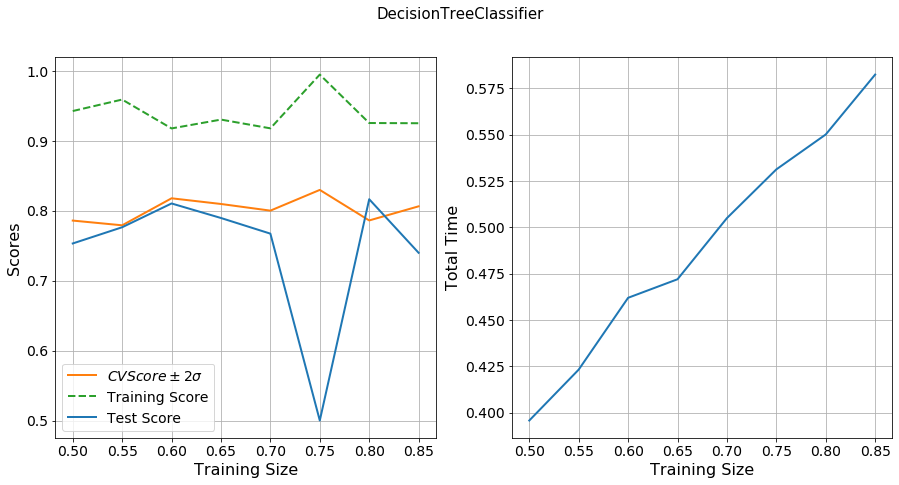

CPU times: user 31.5 s, sys: 9.32 s, total: 40.8 s
Wall time: 16.9 s


In [84]:
%%time

dt = {}
clf = DT(random_state=random_state)
params={'criterion':['gini', 'entropy'],'max_depth':[6,7,8,9]}
verbose=1

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)
dt = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=False)
print("Parameter analysis completed \n\n")

verbose=0
clf = DT(criterion='entropy', max_depth=7, random_state=random_state)
n  = np.arange(0.5,0.9,0.05)
params={}

dt_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=True)
    

###  Random Forest

Random Forest utilizes bagging technique by training several weak learners on samples of data and then assigns labels based on the average scores of all learners. One of the problems with decision trees include fitting the noise along with the real data which leads to bad testing scores. However, averaging over multiple trees can help reduce the variance of the model thus limiting this problem. Again, as in decision trees, we consider the max_depth of each tree and attribute selection criterion for optimization. We also consider a wide range of learners (n_estimators). 

__Results__ : 
* The results between testing and cross validation scores are much more comparable in this case compared to decision trees. 
* The overall performance has also improved with cross validation scores reaching 85% while test scores reach upto 82%. 
* Training multiple decision trees can be expensive which leads to significant increase in the training time. 

In [85]:
%%time
clf = RandomForestClassifier(n_jobs=1, random_state=random_state)
params={'n_estimators':[10,20,40,60],'criterion':['gini', 'entropy'],'max_depth':[7,8,9,10,12]}
verbose=1  

#Finding optimal training data size    
n  = np.arange(0.4,0.9,0.1)
rf = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=False)

print("Parameter analysis completed \n\n")



----------------------------------------------------------------------------------------------------
Training Fraction = 0.4, Best Model parameters - {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 10}
Training Fraction = 0.5, Best Model parameters - {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 10}
Training Fraction = 0.6, Best Model parameters - {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 40}
Training Fraction = 0.7, Best Model parameters - {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 40}
Training Fraction = 0.8, Best Model parameters - {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 20}
Parameter analysis completed 


CPU times: user 4min 38s, sys: 3.83 s, total: 4min 42s
Wall time: 4min 34s


----------------------------------------------------------------------------------------------------


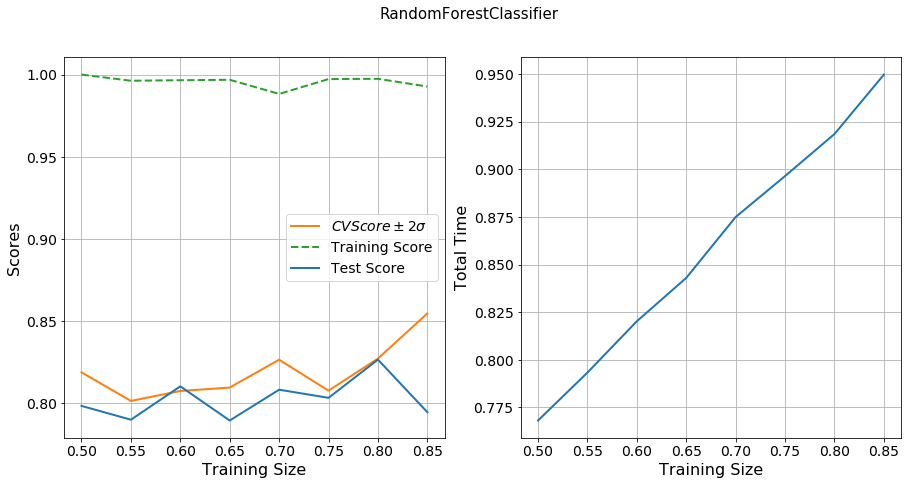

In [87]:
def find_bestparam(clf_dict, param_name):
    a = np.asarray([clf_dict[key].best_params[param_name] for key in clf_dict.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]
  
    
best_criterion = find_bestparam(rf,'criterion')
best_max_depth = find_bestparam(rf,'max_depth')
best_n_estimator = find_bestparam(rf,'n_estimators')


verbose=0
clf = RandomForestClassifier(n_jobs=1, criterion=best_criterion, n_estimators= best_n_estimator, max_depth=best_max_depth, random_state=random_state)
params={}#'n_estimators':[5,10,20,40],'criterion':['gini', 'entropy'],'max_depth':[6,7,8,9]}
n  = np.arange(0.5,0.9,0.05)
params={}

rf_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=True)
    

###  K-Nearest Neighbours (KNN)

KNN utilizes instance based learning approach by choosing K nearest neighbours and predicting the output using majority vote. SKLearn allows two ways to compute the majority weight - first using uniform weights to all the neighbours and second by assigning the weights based on inverse distance metric. To compute the distance, it again uses two different ways - L1 norm and L2 norm. We search over these three parameters to find the best scores. 

__Parameters__ - 
* n_neighbours - Number of nearest neighbours
* Weight - weight for each neighbour's vote
* p - Distance parameter


__Results__:
* We see that for most training data size vote of small number of nearest neighbours work well. The weight itself can be uniform or weighted by distance from the original point computed using L1 norm. 
* While the training scores are perfect, CV scores are ~85% which is better than most other algorithms. Test scores however are lower ranging from 70-80%.
* This method is also extremely fast compared to few previous methods. 


In [88]:
%%time
clf = KNeighborsClassifier()
params={'n_neighbors':[1,3,5,7,9,15,20],'weights':['uniform', 'distance'], 'p':[1,2]}
        
rf = {}
verbose=1  

#Finding optimal training data size    
n  = np.arange(0.4,0.9,0.05)

knn = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=False)

----------------------------------------------------------------------------------------------------
Training Fraction = 0.4, Best Model parameters - {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.45, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.5, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Training Fraction = 0.55, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Training Fraction = 0.6, Best Model parameters - {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.65, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Training Fraction = 0.7, Best Model parameters - {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Training Fraction = 0.75, Best Model parameters - {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Training Fraction = 0.8, Best Model parameters - {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
Training

----------------------------------------------------------------------------------------------------


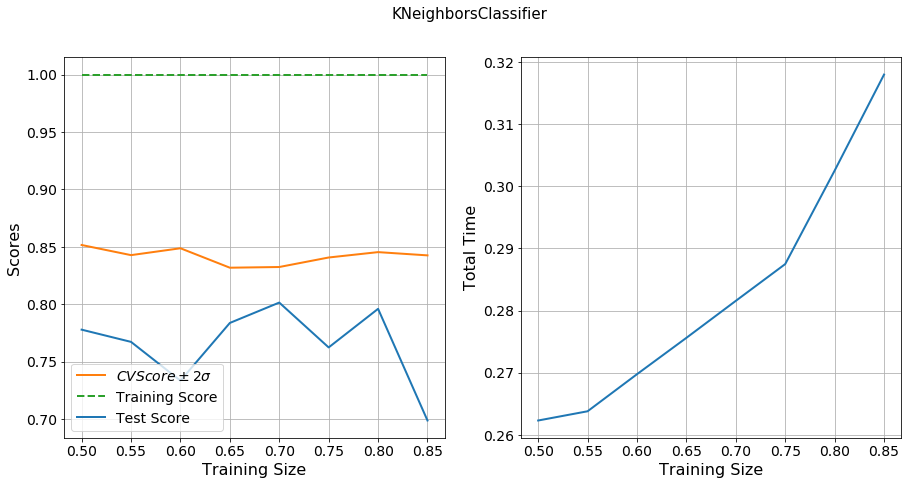

CPU times: user 9.74 s, sys: 4.73 s, total: 14.5 s
Wall time: 2.5 s


In [91]:
%%time

def find_bestparam(clf_dict, param_name):
    a = np.asarray([clf_dict[key].best_params[param_name] for key in clf_dict.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]
  
    
best_n_neighbors = find_bestparam(knn,'n_neighbors')
best_weight = find_bestparam(knn,'weights')
best_p = find_bestparam(knn,'p')

clf = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weight, p=best_p)
params={}
verbose=0  

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)

knn_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, show_plot=True)

### Classifier : Support Vector Machines (SVM)

SVM is another linearized method which 


In [92]:
%%time
clf = SVC(decision_function_shape='ovr', random_state=random_state)  
params={'C':10.**np.arange(0,2,0.4),'kernel':['poly', 'rbf', 'sigmoid']}
rf = {}
verbose=1

#Finding optimal training data size    
n  = np.arange(0.4,0.9,0.05)
svm = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=False)


----------------------------------------------------------------------------------------------------
Training Fraction = 0.4, Best Model parameters - {'C': 15.848931924611142, 'kernel': 'rbf'}
Training Fraction = 0.45, Best Model parameters - {'C': 6.309573444801933, 'kernel': 'rbf'}
Training Fraction = 0.5, Best Model parameters - {'C': 6.309573444801933, 'kernel': 'rbf'}
Training Fraction = 0.55, Best Model parameters - {'C': 2.51188643150958, 'kernel': 'rbf'}
Training Fraction = 0.6, Best Model parameters - {'C': 2.51188643150958, 'kernel': 'rbf'}
Training Fraction = 0.65, Best Model parameters - {'C': 2.51188643150958, 'kernel': 'rbf'}
Training Fraction = 0.7, Best Model parameters - {'C': 2.51188643150958, 'kernel': 'rbf'}
Training Fraction = 0.75, Best Model parameters - {'C': 6.309573444801933, 'kernel': 'rbf'}
Training Fraction = 0.8, Best Model parameters - {'C': 2.51188643150958, 'kernel': 'rbf'}
Training Fraction = 0.85, Best Model parameters - {'C': 6.309573444801933, 'kern

----------------------------------------------------------------------------------------------------


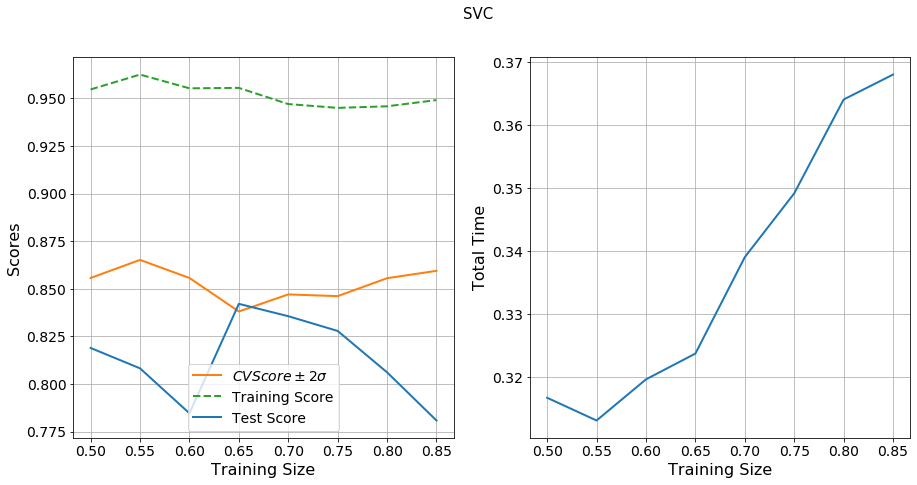

In [93]:
def find_bestparam(clf_dict, param_name):
    a = np.asarray([clf_dict[key].best_params[param_name] for key in clf_dict.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]
  
    
best_C = find_bestparam(svm,'C')
best_kernel = find_bestparam(svm,'kernel')


clf = SVC(decision_function_shape='ovr', kernel=best_kernel, C=best_C, random_state=random_state)  
params={}

verbose=0

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)
svm_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=True)


### Classifier : Naive Bayes

----------------------------------------------------------------------------------------------------


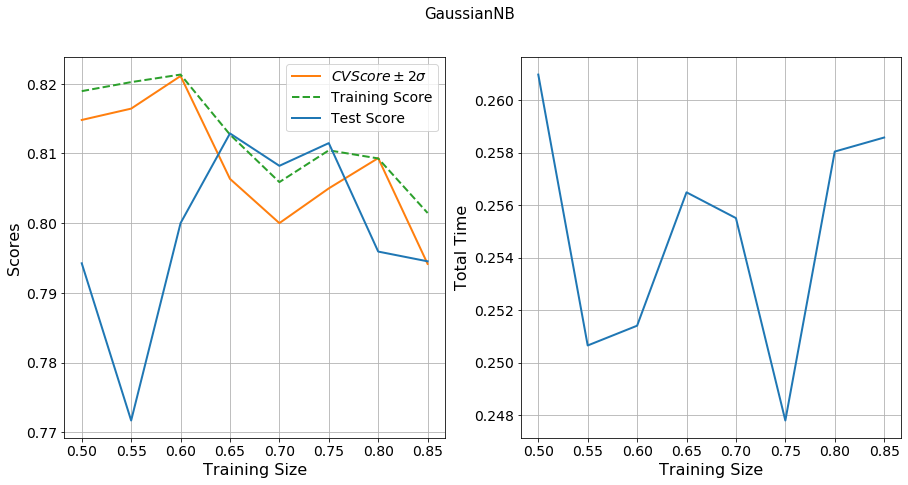

CPU times: user 9.08 s, sys: 4.9 s, total: 14 s
Wall time: 2.27 s


In [94]:
%%time
clf = GaussianNB()  
params={} 
        
rf = {}
verbose=0 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)

gnb = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=True)


### Classifier : Neural Network

In [97]:
%%time
clf = MLPClassifier(alpha=0.1, solver='adam', max_iter=1000, random_state=random_state)  
params={ 'hidden_layer_sizes':[10,50,100,200], 'activation':['identity', 'logistic', 'tanh', 'relu']} 

verbose=1 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.1)
ann = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=False)


----------------------------------------------------------------------------------------------------
Training Fraction = 0.5, Best Model parameters - {'activation': 'relu', 'hidden_layer_sizes': 50}
Training Fraction = 0.6, Best Model parameters - {'activation': 'relu', 'hidden_layer_sizes': 200}
Training Fraction = 0.7, Best Model parameters - {'activation': 'relu', 'hidden_layer_sizes': 200}
Training Fraction = 0.8, Best Model parameters - {'activation': 'relu', 'hidden_layer_sizes': 100}
CPU times: user 1min 21s, sys: 53.1 s, total: 2min 14s
Wall time: 3min 23s


----------------------------------------------------------------------------------------------------
Training Fraction = 0.5, Best Model parameters - {}
Training Fraction = 0.55, Best Model parameters - {}
Training Fraction = 0.6, Best Model parameters - {}
Training Fraction = 0.65, Best Model parameters - {}
Training Fraction = 0.7, Best Model parameters - {}
Training Fraction = 0.75, Best Model parameters - {}
Training Fraction = 0.8, Best Model parameters - {}
Training Fraction = 0.85, Best Model parameters - {}


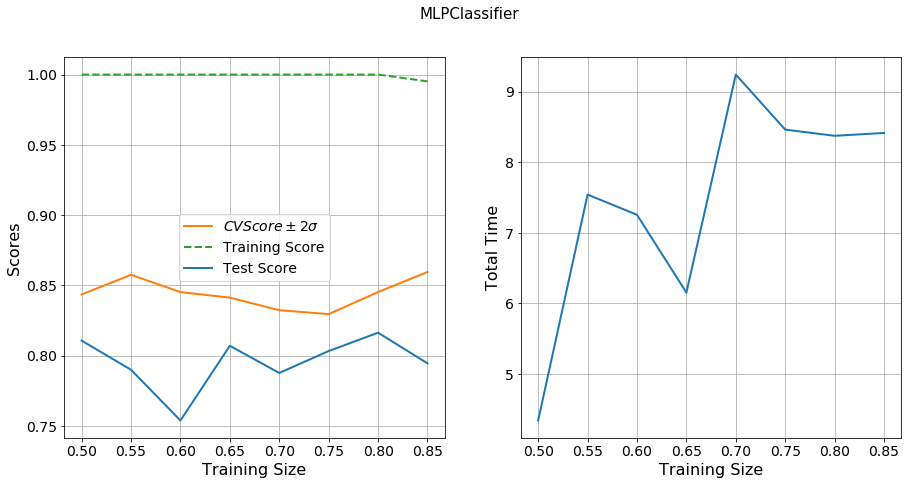

CPU times: user 2min 53s, sys: 1min 58s, total: 4min 52s
Wall time: 1min


In [98]:
%%time

def find_bestparam(clf_dict, param_name):
    a = np.asarray([clf_dict[key].best_params[param_name] for key in clf_dict.keys()])
    val,count = np.unique(a, return_counts=True)
    max_count_idx = np.argmax(count)
    return  val[max_count_idx]  
    
best_hlayer_size = find_bestparam(ann,'hidden_layer_sizes')
best_activation = find_bestparam(ann,'activation')


clf = MLPClassifier(alpha=0.1, solver='adam', hidden_layer_sizes=best_hlayer_size, activation=best_activation, max_iter=1000, random_state=random_state)  
params={ }#'hidden_layer_sizes':[10,50,100,200], 'activation':['identity', 'logistic', 'tanh', 'relu']} 

verbose=1 

#Finding optimal training data size    
n  = np.arange(0.5,0.9,0.05)
ann_final = analyse_classifier(clf, params, waveform_data_ht, y_numeric, n, 45, random_state, verbose=verbose, parallelize=True, show_plot=True)


In [126]:
var = ann_final[0.5]
var.testing_score

0.8106995884773662

/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/nethome/bkhamesra3/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


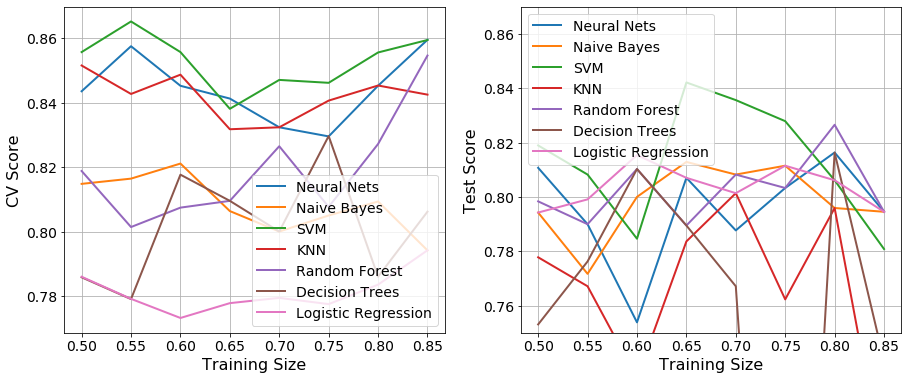

In [130]:
#Model Comparisons

plt.figure(figsize=(15,6))
clf = {'Neural Nets':ann_final, 'Naive Bayes': gnb, 'SVM':svm_final,\
       'KNN':knn_final,'Random Forest':rf_final, 'Decision Trees':dt_final,'Logistic Regression':lr_final }

clf_crossval_score = lambda train_size: classifier[train_size].cv_score.mean()
clf_test_score = lambda train_size: classifier[train_size].testing_score

for key in clf.keys():
    classifier = clf[key]
    
    plt.subplot(121)
    
    #plt.plot(train_size,classifier[train_size].cv_score.mean())
    plt.plot(n, list(map(clf_crossval_score, n)), label=key)
    plt.xlabel('Training Size')
    plt.ylabel('CV Score')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(n, list(map(clf_test_score, n)), label=key)
    plt.xlabel('Training Size')
    plt.ylabel('Test Score')
    plt.ylim(0.75,0.87)
    plt.legend()

    
plt.show()

       